# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# Functions

In [2]:

def power_cubic_regression(df):
    
    X = df[["cubic_wind_speed"]].values
    y = df[["grid_power_active_avg"]].values
    X = np.hstack((np.ones((X.shape[0], 1)), X))

    # Create linear regression object
    regr = LinearRegression(fit_intercept=False)
    # Train the model using the training sets
    regr.fit(X, y)


    # Return regression and coefficients
    return(
        regr,
        regr.coef_[0][0],
        regr.coef_[0][1],
    )

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def fit_sigmoid(df):
    
    X = df[["environment_wind_speed_avg"]].values
    y = df[["grid_power_active_avg"]].values
    
    p0 = [max(y), np.median(X),1,min(y)] # this is an mandatory initial guess
    popt, pcov = curve_fit(sigmoid, X.reshape((X.shape[0],)), y.reshape((X.shape[0],)),p0, method='dogbox')
    return popt


In [3]:
def power_curve_stats(df, prev_week_model, model_type = "lr"):

    # We create 3 masks. The aim of this mask is to exclude differents part of the curve that resemble the anomalies.
    # for example the flattening of the curve at the top and the flattening of the curve when is closer to 0
    mask1 = df["power_diff"] > global_stats["max_power"]/2
    mask2 = df["grid_power_active_avg"] < 100
    mask3 = df["grid_power_active_avg"] < global_stats["max_power"]*0.90
    
    #we apply the mask in different ways, for example we exclude points <100 MW
    total_mask = mask1 & ~mask2 & mask3
    
    #there are two DF, anomalies and normal
    df_anom = df[total_mask]

    df_normal = df[~total_mask]
    
    #We create a dictionary inside the function that would store different variables that we create in order to spot the anomalies
    #most of this variables are an average/std dev/max,min of the points at the specific week
    stats_dict = dict()
    
    stats_dict["std_power_anom"] = df_anom["grid_power_active_avg"].std()

    stats_dict["std_power_normal"] = df_normal["grid_power_active_avg"].std()
 
    stats_dict["std_speed_anom"] = df_anom["environment_wind_speed_avg"].std()

    stats_dict["std_speed_normal"] =df_normal["environment_wind_speed_avg"].std()
    
    stats_dict["ratio_power_wind_anom"] = stats_dict["std_power_anom"]/stats_dict["std_speed_anom"]
    
    stats_dict["ratio_power_wind_normal"] =  stats_dict["std_power_normal"] / stats_dict["std_speed_normal"] 
    
    stats_dict["prev_week_model"] = prev_week_model
    
    stats_dict["power_diff"] = df["power_diff"].mean()
    
    stats_dict["power_diff_normal"] = df_normal["power_diff"].mean()
    
    stats_dict["power_diff_anom"] = df_anom["power_diff"].mean()
    
    #in order the avoid outliers we calculate the IQR. And it will be used to spot Power Curtailments
    Q1 = df_anom["grid_power_active_avg"].quantile(0.25)
    Q3 = df_anom["grid_power_active_avg"].quantile(0.75)
    stats_dict["power_iqr"] = Q3-Q1
    
    #This will be used to spot Power Curve Shifts
    max_wind = df_anom["environment_wind_speed_avg"].max()
    min_wind = df_anom["environment_wind_speed_avg"].min()
    stats_dict["anom_wind_diff"] = max_wind - min_wind
    
    
    if model_type == "lr":
        stats_dict["lr_model"],_,_ = power_cubic_regression(df[~total_mask & mask3 & ~mask2])
    elif model_type == "sigmoid":
        stats_dict["lr_model"]= fit_sigmoid(df[mask1])
    
    stats_dict["anomalies"] = total_mask
    
    #create the X for the model
    X = np.linspace(0,global_stats["max_wind_speed"],200).reshape((-1,1))
    
    #we need to the reshape it
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    
    #This are the rules to spot Power Curve Shifts.
    #Is the difference of the power curve between two weeks ranges more than 9% it will be a PCS
    #The numbers "week_diff" is divided by the max_power in order to scale it to each Turbine
    # The thresholds of 4% and 9% were fixed by observing many turbines. This number could be change if it's needed
    if prev_week_model:
        stats_dict["week_diff"] = (sum(prev_week_model.predict(X) - stats_dict["lr_model"].predict(X))/len(X))[0]
        if abs(stats_dict["week_diff"] / global_stats["max_power"]) > 0.09:
            stats_dict["is_power_shift"] = "Very Likely"
        elif 0.04 < abs(stats_dict["week_diff"] / global_stats["max_power"]) < 0.09:
            stats_dict["is_power_shift"] = "Probably"
        else:
            stats_dict["is_power_shift"] = "Not Power Shift"
    else:
        stats_dict["week_diff"] = 0
        stats_dict["is_power_shift"] = "Not Power Shift"
          
    # This are the rules to spot a Power Curtailment
    # This relates the max_power of the curve with the dispersion of the anomalies along the Y axis
    # Ths more disperse the anomalies the less likely it will be labeled as an anomally 
    # Then we compare the wind difference between the points and the ideal curve and we divide it by the max_wind_speed 
    # so it can be scaled for all the wind turbines
    if stats_dict["power_iqr"] < global_stats["max_power"]/50:
        df["anomally_type"][total_mask] = "Power_Curtailments"
        if stats_dict["anom_wind_diff"]/ global_stats["max_wind_speed"] > 0.05:
            stats_dict["is_power_curtailmemt"] = True
        else:
            stats_dict["is_power_curtailmemt"] = False
    else:
        stats_dict["is_power_curtailmemt"] = False
    
    return stats_dict

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [5]:
# plotting function. Is using the linear model to create the prediction
def plot_power_curve(group, lr_model, anomalies, prev_week_model):
    X = group[["cubic_wind_speed"]].values
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    y = group["grid_power_active_avg"]
    y_hat = group["prediction"]
    y_hat_week = lr_model.predict(X)
    if prev_week_model:
        y_hat_prev_week_model = prev_week_model.predict(X)
    y_anomalies = group[anomalies]["grid_power_active_avg"].values
    x_anomalies = group[anomalies]["cubic_wind_speed"].values
    plt.plot(X[:, 1]**(1/3), y, "o")
    plt.plot(X[:, 1]**(1/3), y_hat, c="red")
    plt.plot(X[:, 1]**(1/3), y_hat_week, c="green")
    if prev_week_model:
        plt.plot(X[:, 1]**(1/3), y_hat_prev_week_model, c="black")
    plt.plot(x_anomalies**(1/3), y_anomalies, "o",c="red")
    plt.ylim((0,global_stats["max_power"]*1.1))
    plt.xlim((0,15))

In [6]:
# This code was created with the intention of being used for a prefined curve
# In case the user has a predefined curve that resembles the "optimal curve" this could be used
def plot_power_curve_predefined(group, anomalies):
    X = group[["cubic_wind_speed"]].values
    #X = np.hstack((np.ones((X.shape[0], 1)), X))
    y = group["grid_power_active_avg"]
    y_hat = group["prediction"]
    #y_hat_week = group["prediction"] # changed this
    y_anomalies = group[anomalies]["grid_power_active_avg"].values
    x_anomalies = group[anomalies]["cubic_wind_speed"].values
    plt.plot(X[:, 1]**(1/3), y, "o")
    plt.plot(X[:, 1]**(1/3), y_hat, c="red")
    plt.plot(X[:, 1]**(1/3), y_hat_week, c="green")
    plt.plot(x_anomalies**(1/3), y_anomalies, "o",c="red")
    plt.ylim((0,max(y)*1.1))

# Data Import

In [7]:
# the final_data files include more columns than the original data, such as turbines ID, type of problem, etc.
# this files should be created with the data_merge2 notebook
# Select the wind turbine ID you want to pick analyze
ID = "ID7"
data_file = "/Users/francopallitto/Documents/DS_projects/nispera/data/processed/final_data/final_data_60min.csv"
df = pd.read_csv(data_file)

In [8]:
df = df[(df["ID"] == ID)].copy()
df["datetime"] = pd.to_datetime(df['datetime'].str.strip(), format='%Y-%m-%d %H:%M:%S')
df["week"] = df["datetime"].dt.isocalendar().week

In [9]:
# we create the cubic_wind_speed column in order to create a linear model for the power curve
df["cubic_wind_speed"] = df["environment_wind_speed_avg"]**3
# wind direction it's not a factor that affects the power curve shift, so we drop it
df.drop(columns = "environment_wind_direction_absolute_avg", inplace = True)
df.dropna(subset = ["environment_wind_speed_avg","grid_power_active_avg"], inplace = True)
df.sort_values(by = ["week", "datetime"], inplace = True)
df["anomally_type"] = None
df_by_week = df.groupby(["week"])

In [10]:
# we create the dictionary with Global Stats, which is different from the one in the function
global_stats = dict()
global_stats["max_power"] = df["grid_power_active_avg"].max()
global_stats["min_power"] = df["grid_power_active_avg"].min()
global_stats["max_wind_speed"] = df["environment_wind_speed_avg"].max()
global_stats["min_wind_speed"] = df["environment_wind_speed_avg"].min()

# Linear Regression for All Weeks

In [11]:
# we have a regression for each week
my_list = []
for name,group in (df_by_week):
    my_list.append(power_cubic_regression(group))

In [12]:
linear_regression_by_week = pd.DataFrame(my_list)

In [13]:
# we take the linear regression with the highest slope and assign it to the variable best_week
best_week = linear_regression_by_week[2].idxmax()

In [14]:
# We create variables to spot the best fuction.
# Again we want to avoid outliers that's why we look for the linear regression closest to the mean in the fist quartile
quarter_week = linear_regression_by_week[2].quantile(0.75)
mean_week = linear_regression_by_week[2].mean()
find_nearest(linear_regression_by_week[2], quarter_week)

result = np.where(linear_regression_by_week[2] == find_nearest(linear_regression_by_week[2], quarter_week))
result[0][0]
best_quarter =  np.where(linear_regression_by_week[2] == find_nearest(linear_regression_by_week[2], quarter_week))[0][0]

In [15]:
best_model = linear_regression_by_week[0][best_week]  
#here you can change it between best_quarter and best_week

In [16]:
# We create the X and the Y
X = df[["cubic_wind_speed"]].values
X = np.hstack((np.ones((X.shape[0], 1)), X))
df["prediction"] = best_model.predict(X)
df["power_diff"] = df["prediction"] - df["grid_power_active_avg"]
y = df["grid_power_active_avg"]
y_hat = df["prediction"]

(0.0, 3796.1916666666666)

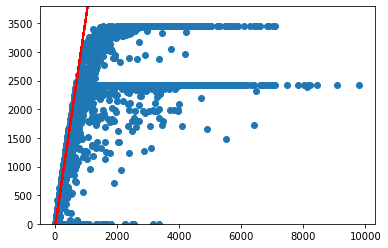

In [17]:
plt.plot(X[:, 1], y, "o")
plt.plot(X[:, 1], y_hat, c="red")
plt.ylim((0,max(y)*1.1))

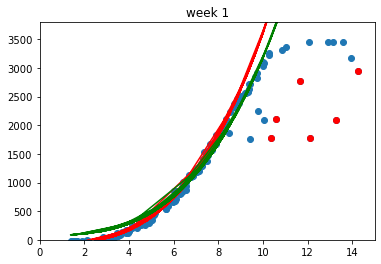

W_diff: 0
Pw_diff: 380.41215410094645
Pw_diff_normal: 233.0542827142516
Pw_diff_anom: 4359.074681541708
is_power_curtailment: False
power_iqr: 746.3833333333334
max_power/10: 34.51083333333333
wind_difference: 0.18224299065420563
week_difference: 0.0
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


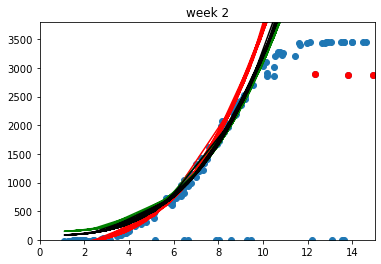

W_diff: -63.76738632305639
Pw_diff: 1520.404069190076
Pw_diff_normal: 1370.7954788645682
Pw_diff_anom: 7654.356272535893
is_power_curtailment: True
power_iqr: 57.87916666666615
max_power/10: 34.51083333333333
wind_difference: 0.15031152647975063
week_difference: -0.018477498270511115
is_power_shift: Not Power Shift


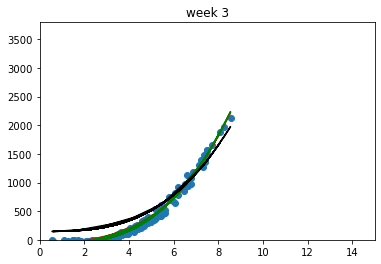

W_diff: 219.8962193279029
Pw_diff: 1.715453176335099e-13
Pw_diff_normal: 1.715453176335099e-13
Pw_diff_anom: nan
is_power_curtailment: False
power_iqr: nan
max_power/10: 34.51083333333333
wind_difference: nan
week_difference: 0.06371802651184012
is_power_shift: Probably


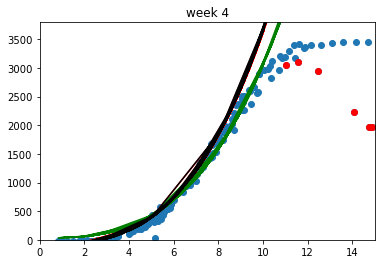

W_diff: -108.75132132335793
Pw_diff: 832.0109976029886
Pw_diff_normal: 565.6239763759992
Pw_diff_anom: 6958.912485823748
is_power_curtailment: False
power_iqr: 1023.8666666666663
max_power/10: 34.51083333333333
wind_difference: 0.22429906542056088
week_difference: -0.031512226978975086
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


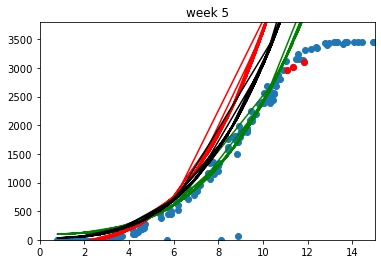

W_diff: -59.76004810459594
Pw_diff: 2179.652824513794
Pw_diff_normal: 2175.9459066162026
Pw_diff_anom: 2383.5333088812877
is_power_curtailment: False
power_iqr: 66.73333333333267
max_power/10: 34.51083333333333
wind_difference: 0.03504672897196262
week_difference: -0.01731631558339534
is_power_shift: Not Power Shift


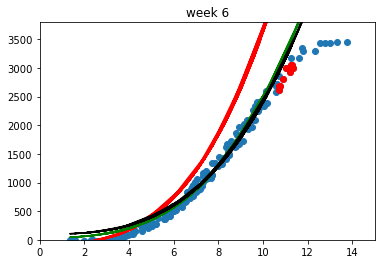

W_diff: 59.64416640030871
Pw_diff: 650.2685406772952
Pw_diff_normal: 574.3425365685935
Pw_diff_anom: 1991.6279465977032
is_power_curtailment: False
power_iqr: 311.41666666666697
max_power/10: 34.51083333333333
wind_difference: 0.03115264797507794
week_difference: 0.017282737227530116
is_power_shift: Not Power Shift


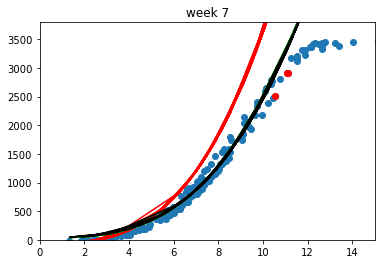

W_diff: 10.186899268577907
Pw_diff: 960.243192730966
Pw_diff_normal: 942.3630076909722
Pw_diff_anom: 1943.6533699306412
is_power_curtailment: False
power_iqr: 201.05833333333294
max_power/10: 34.51083333333333
wind_difference: 0.02647975077881619
week_difference: 0.002951797532729696
is_power_shift: Not Power Shift


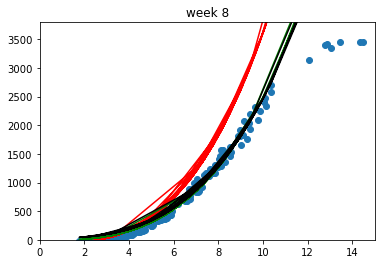

W_diff: 37.84456796273227
Pw_diff: 484.1482734966966
Pw_diff_normal: 484.1482734966966
Pw_diff_anom: nan
is_power_curtailment: False
power_iqr: nan
max_power/10: 34.51083333333333
wind_difference: nan
week_difference: 0.010965996560326161
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


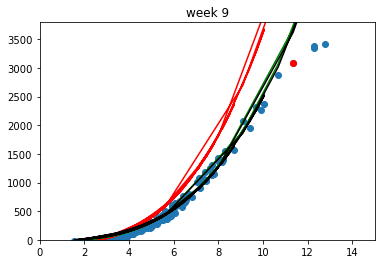

W_diff: 9.642616787333171
Pw_diff: 250.85020312311545
Pw_diff_normal: 239.0439454090395
Pw_diff_anom: 2222.495241373801
is_power_curtailment: False
power_iqr: 0.0
max_power/10: 34.51083333333333
wind_difference: 0.0
week_difference: 0.0027940840182550906
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


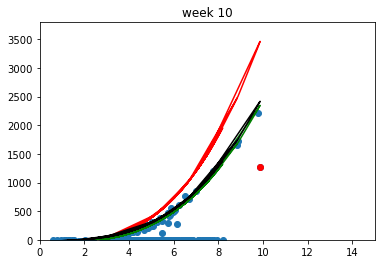

W_diff: 36.48991934523306
Pw_diff: 473.15226673230893
Pw_diff_normal: 462.904582613494
Pw_diff_anom: 2184.5155145744234
is_power_curtailment: False
power_iqr: 0.0
max_power/10: 34.51083333333333
wind_difference: 0.0
week_difference: 0.010573468044884378
is_power_shift: Not Power Shift


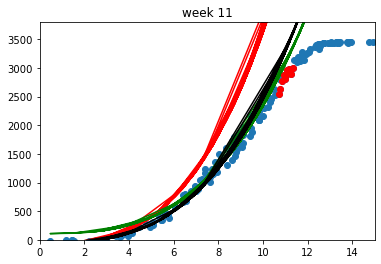

W_diff: -160.28624433203248
Pw_diff: 1980.269923210879
Pw_diff_normal: 1977.9834945267894
Pw_diff_anom: 2012.9034962474316
is_power_curtailment: False
power_iqr: 174.9333333333334
max_power/10: 34.51083333333333
wind_difference: 0.02959501557632405
week_difference: -0.04644519672528892
is_power_shift: Probably


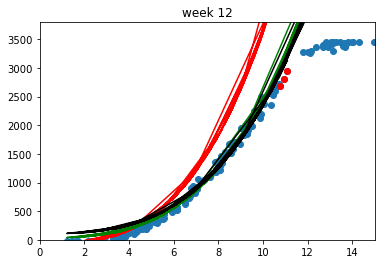

W_diff: 71.89138900510996
Pw_diff: 3210.5042829104295
Pw_diff_normal: 3233.911303601301
Pw_diff_anom: 1923.1181449125609
is_power_curtailment: False
power_iqr: 126.46666666666715
max_power/10: 34.51083333333333
wind_difference: 0.016355140186915872
week_difference: 0.020831542463992457
is_power_shift: Not Power Shift


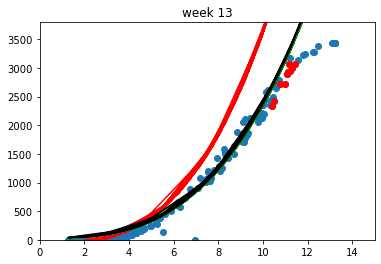

W_diff: 6.503784815709196
Pw_diff: 722.5347159166764
Pw_diff_normal: 640.6522572862035
Pw_diff_anom: 2016.2775622781476
is_power_curtailment: False
power_iqr: 267.72916666666697
max_power/10: 34.51083333333333
wind_difference: 0.04672897196261683
week_difference: 0.0018845632479779382
is_power_shift: Not Power Shift


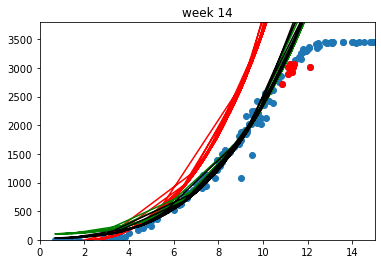

W_diff: -73.15524769630224
Pw_diff: 3247.4329813859536
Pw_diff_normal: 3302.212294316024
Pw_diff_anom: 2279.6651196213384
is_power_curtailment: False
power_iqr: 100.48333333333312
max_power/10: 34.51083333333333
wind_difference: 0.059190031152648016
week_difference: -0.021197763319624925
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


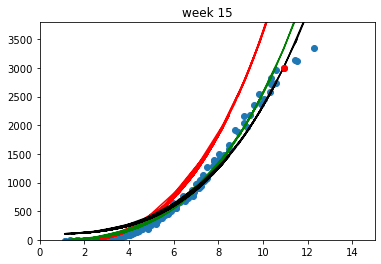

W_diff: 104.2903225204302
Pw_diff: 264.4387318061404
Pw_diff_normal: 255.6001296673418
Pw_diff_anom: 1740.4852889855238
is_power_curtailment: False
power_iqr: 0.0
max_power/10: 34.51083333333333
wind_difference: 0.0
week_difference: 0.030219589748271374
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


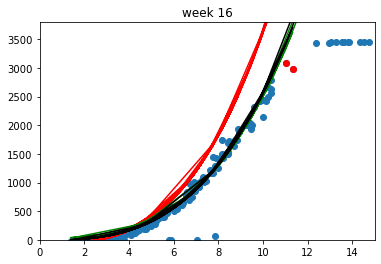

W_diff: -34.24722518390692
Pw_diff: 693.3774918251418
Pw_diff_normal: 677.3559872532242
Pw_diff_anom: 2023.1623712942971
is_power_curtailment: False
power_iqr: 52.43333333333294
max_power/10: 34.51083333333333
wind_difference: 0.014797507788162067
week_difference: -0.00992361582611458
is_power_shift: Not Power Shift


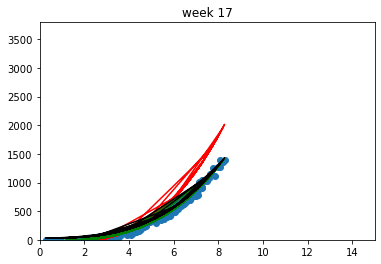

W_diff: 50.24906990952958
Pw_diff: 132.35581487927374
Pw_diff_normal: 132.35581487927374
Pw_diff_anom: nan
is_power_curtailment: False
power_iqr: nan
max_power/10: 34.51083333333333
wind_difference: nan
week_difference: 0.014560375701213508
is_power_shift: Not Power Shift


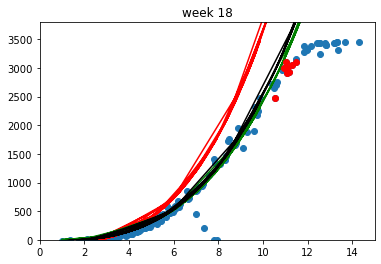

W_diff: -21.085253054534196
Pw_diff: 830.3743887340388
Pw_diff_normal: 771.9326526754202
Pw_diff_anom: 1999.2091099064107
is_power_curtailment: False
power_iqr: 143.0374999999999
max_power/10: 34.51083333333333
wind_difference: 0.04439252336448612
week_difference: -0.006109749031811517
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


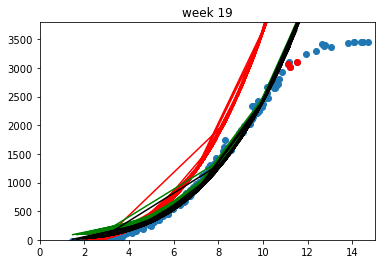

W_diff: -79.70346350161691
Pw_diff: 774.9676250967925
Pw_diff_normal: 749.9961094037628
Pw_diff_anom: 2148.400988213431
is_power_curtailment: False
power_iqr: 39.97499999999991
max_power/10: 34.51083333333333
wind_difference: 0.018691588785046665
week_difference: -0.023095201072595634
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


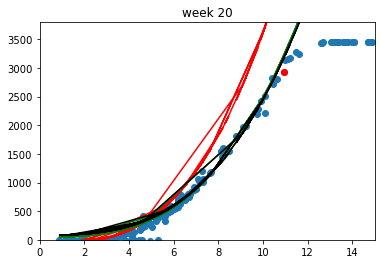

W_diff: 32.85622726703798
Pw_diff: 1701.2849975225677
Pw_diff_normal: 1700.3964376210063
Pw_diff_anom: 1849.6745010832992
is_power_curtailment: False
power_iqr: 0.0
max_power/10: 34.51083333333333
wind_difference: 0.0
week_difference: 0.00952055458924627
is_power_shift: Not Power Shift


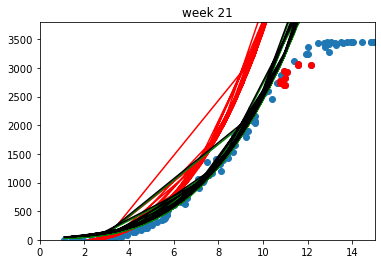

W_diff: 23.088144440521106
Pw_diff: 1724.9917045558582
Pw_diff_normal: 1693.6150558147606
Pw_diff_anom: 2172.822054769698
is_power_curtailment: False
power_iqr: 241.39999999999964
max_power/10: 34.51083333333333
wind_difference: 0.06464174454828667
week_difference: 0.006690115019106399
is_power_shift: Not Power Shift


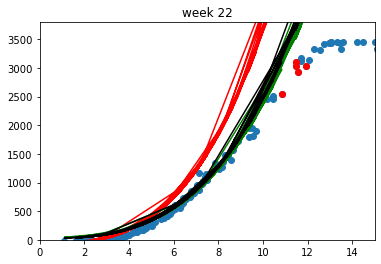

W_diff: -13.780276888066307
Pw_diff: 1061.1550482790835
Pw_diff_normal: 1015.6662242632286
Pw_diff_anom: 2544.0907111959614
is_power_curtailment: False
power_iqr: 94.40000000000055
max_power/10: 34.51083333333333
wind_difference: 0.0498442367601246
week_difference: -0.003993029306179115
is_power_shift: Not Power Shift


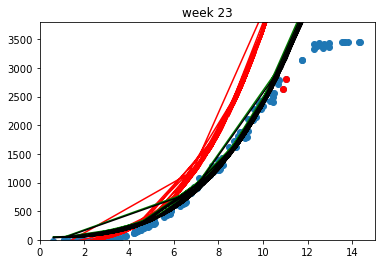

W_diff: -9.83870293935599
Pw_diff: 994.3994438994598
Pw_diff_normal: 981.5868113394367
Pw_diff_anom: 2057.8479463813683
is_power_curtailment: False
power_iqr: 83.4666666666667
max_power/10: 34.51083333333333
wind_difference: 0.007788161993769526
week_difference: -0.002850902742430442
is_power_shift: Not Power Shift


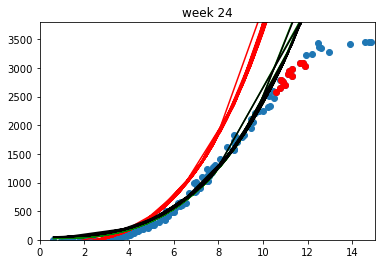

W_diff: 26.93290146255039
Pw_diff: 710.585312479159
Pw_diff_normal: 585.0698846252599
Pw_diff_anom: 2207.115413814111
is_power_curtailment: False
power_iqr: 220.4000000000001
max_power/10: 34.51083333333333
wind_difference: 0.059190031152648016
week_difference: 0.007804187514804644
is_power_shift: Not Power Shift


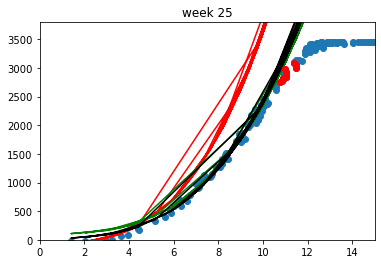

W_diff: -78.18661559694706
Pw_diff: 3689.920879809882
Pw_diff_normal: 3830.203726959032
Pw_diff_anom: 2017.3177022623322
is_power_curtailment: False
power_iqr: 162.25
max_power/10: 34.51083333333333
wind_difference: 0.03348909657320882
week_difference: -0.022655673029323278
is_power_shift: Not Power Shift


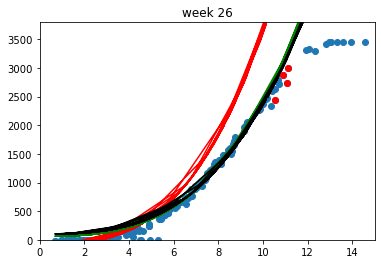

W_diff: 37.44772084089087
Pw_diff: 552.3770950034747
Pw_diff_normal: 518.6044699839711
Pw_diff_anom: 1937.054720803122
is_power_curtailment: False
power_iqr: 236.99166666666633
max_power/10: 34.51083333333333
wind_difference: 0.028037383177570162
week_difference: 0.010851004517680207
is_power_shift: Not Power Shift


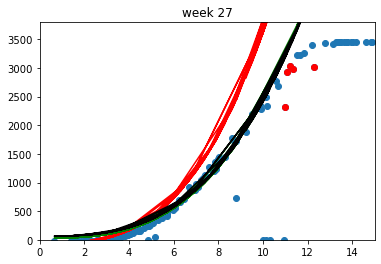

W_diff: 33.79852460457712
Pw_diff: 1583.0878305599024
Pw_diff_normal: 1554.1915875652817
Pw_diff_anom: 2525.1053521845397
is_power_curtailment: False
power_iqr: 90.8166666666666
max_power/10: 34.51083333333333
wind_difference: 0.05996884735202484
week_difference: 0.009793598513870655
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


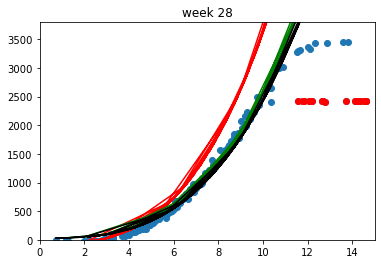

W_diff: -1.6621747433673346
Pw_diff: 1099.0585190996833
Pw_diff_normal: 459.51028573442863
Pw_diff_anom: 6428.627130476805
is_power_curtailment: True
power_iqr: 0.02916666666715173
max_power/10: 34.51083333333333
wind_difference: 0.2032710280373831
week_difference: -0.0004816385415306309
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


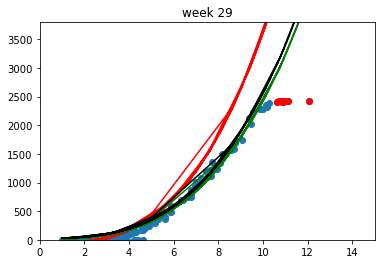

W_diff: 15.72722006353021
Pw_diff: 253.2246998163902
Pw_diff_normal: 144.11114954612398
Pw_diff_anom: 2435.4957052217137
is_power_curtailment: True
power_iqr: 2.875
max_power/10: 34.51083333333333
wind_difference: 0.06853582554517151
week_difference: 0.004557183511514803
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


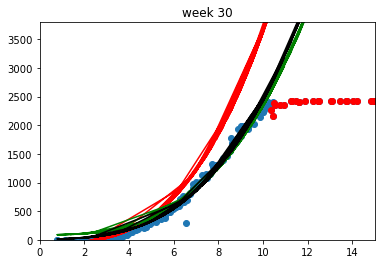

W_diff: -71.22152616596789
Pw_diff: 1187.0979048214574
Pw_diff_normal: 406.67391736631237
Pw_diff_anom: 5262.645394864999
is_power_curtailment: True
power_iqr: 9.949999999999818
max_power/10: 34.51083333333333
wind_difference: 0.2227414330218069
week_difference: -0.02063744027217576
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


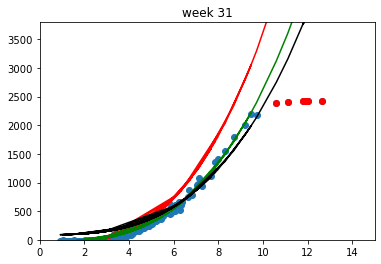

W_diff: 116.82252622820272
Pw_diff: 208.73859820170267
Pw_diff_normal: 88.87941247858032
Pw_diff_anom: 3444.936612726007
is_power_curtailment: True
power_iqr: 0.8374999999996362
max_power/10: 34.51083333333333
wind_difference: 0.09579439252336452
week_difference: 0.03385097227291992
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


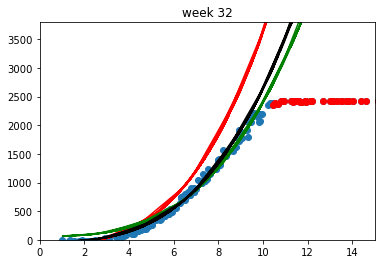

W_diff: -94.35279424710079
Pw_diff: 1797.2517108640636
Pw_diff_normal: 346.52206656603994
Pw_diff_anom: 5885.671617522129
is_power_curtailment: True
power_iqr: 0.06666666666706078
max_power/10: 34.51083333333333
wind_difference: 0.2733644859813083
week_difference: -0.027340050973491646
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


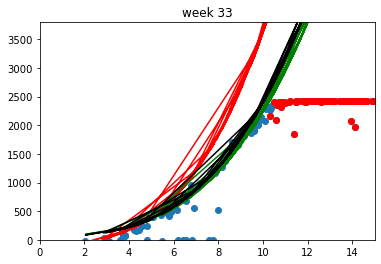

W_diff: -10.994292376256809
Pw_diff: 4475.049549858079
Pw_diff_normal: 675.1577607187862
Pw_diff_anom: 6933.803060477621
is_power_curtailment: True
power_iqr: 0.03333333333330302
max_power/10: 34.51083333333333
wind_difference: 0.3364485981308411
week_difference: -0.0031857510567957336
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


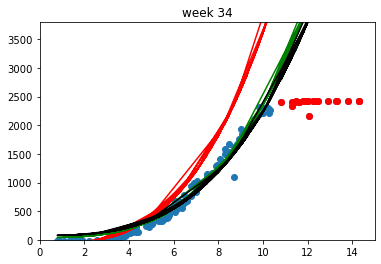

W_diff: 35.99979608023597
Pw_diff: 2399.2641825624805
Pw_diff_normal: 268.44761808635394
Pw_diff_anom: 9217.877188886087
is_power_curtailment: True
power_iqr: 0.09166666666669698
max_power/10: 34.51083333333333
wind_difference: 0.3481308411214952
week_difference: 0.010431447926081947
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


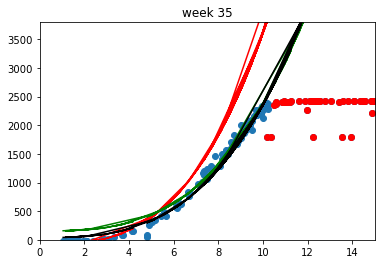

W_diff: -114.97537115833289
Pw_diff: 3252.754132587208
Pw_diff_normal: 551.3815538126075
Pw_diff_anom: 7946.942548162745
is_power_curtailment: True
power_iqr: 1.1000000000003638
max_power/10: 34.51083333333333
wind_difference: 0.43847352024922126
week_difference: -0.033315733076570035
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


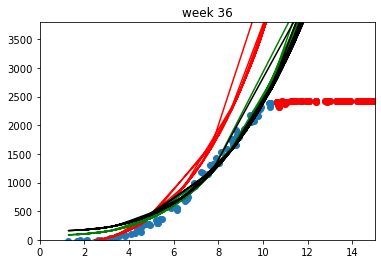

W_diff: 72.41210348284832
Pw_diff: 3942.290118937684
Pw_diff_normal: 364.2408153660993
Pw_diff_anom: 7785.38011166272
is_power_curtailment: True
power_iqr: 0.0500000000001819
max_power/10: 34.51083333333333
wind_difference: 0.3504672897196262
week_difference: 0.020982426817525414
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


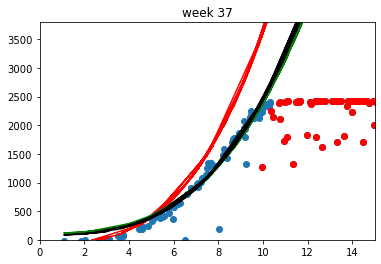

W_diff: -32.386371388435094
Pw_diff: 4215.72843405477
Pw_diff_normal: 521.3941581568864
Pw_diff_anom: 8279.496137542443
is_power_curtailment: True
power_iqr: 26.23333333333312
max_power/10: 34.51083333333333
wind_difference: 0.4750778816199378
week_difference: -0.009384407231092197
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


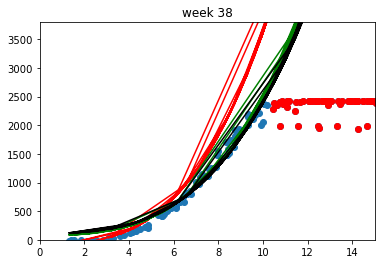

W_diff: 33.124784553286084
Pw_diff: 3619.4781482060775
Pw_diff_normal: 312.86926901972396
Pw_diff_anom: 7256.747915311067
is_power_curtailment: True
power_iqr: 13.137499999999818
max_power/10: 34.51083333333333
wind_difference: 0.40498442367601256
week_difference: 0.009598372845228142
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


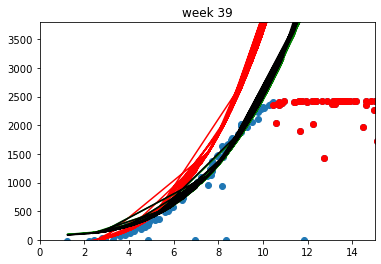

W_diff: -9.52772903336994
Pw_diff: 4723.858712674324
Pw_diff_normal: 472.172209484387
Pw_diff_anom: 9290.484956841292
is_power_curtailment: True
power_iqr: 19.850000000000364
max_power/10: 34.51083333333333
wind_difference: 0.4517133956386294
week_difference: -0.002760793673494779
is_power_shift: Not Power Shift


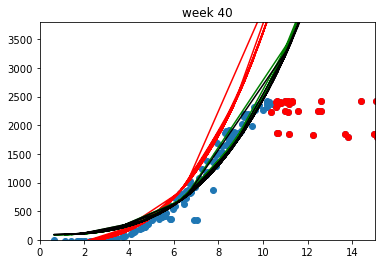

/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


W_diff: 4.1524918875840005
Pw_diff: 1365.3586080830532
Pw_diff_normal: 298.17922157735575
Pw_diff_anom: 5420.640276804707
is_power_curtailment: False
power_iqr: 259.6583333333333
max_power/10: 34.51083333333333
wind_difference: 0.2632398753894082
week_difference: 0.0012032430070511193
is_power_shift: Not Power Shift


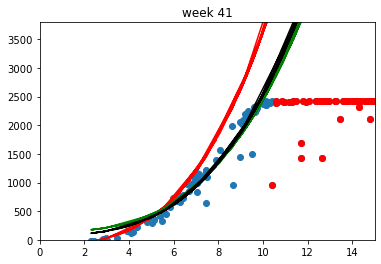

W_diff: -60.90420662566993
Pw_diff: 4904.217104927878
Pw_diff_normal: 383.8704106989798
Pw_diff_anom: 9996.759583236388
is_power_curtailment: True
power_iqr: 0.03333333333330302
max_power/10: 34.51083333333333
wind_difference: 0.514018691588785
week_difference: -0.017647851628909743
is_power_shift: Not Power Shift


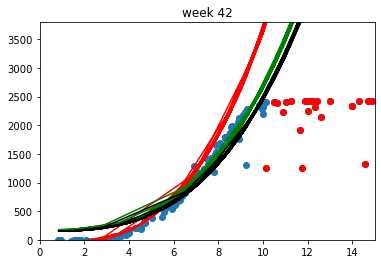

W_diff: -28.360847516527002
Pw_diff: 1314.1109914927565
Pw_diff_normal: 192.754409587635
Pw_diff_anom: 6472.351268256315
is_power_curtailment: False
power_iqr: 143.70416666666642
max_power/10: 34.51083333333333
wind_difference: 0.396417445482866
week_difference: -0.008217954994767924
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


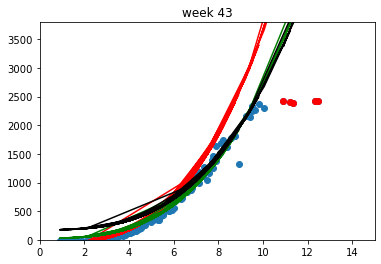

W_diff: 147.54175523240067
Pw_diff: 210.05934810168796
Pw_diff_normal: 112.06787096940681
Pw_diff_anom: 3404.581502614059
is_power_curtailment: True
power_iqr: 13.150000000000091
max_power/10: 34.51083333333333
wind_difference: 0.0732087227414331
week_difference: 0.042752301518576494
is_power_shift: Probably


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


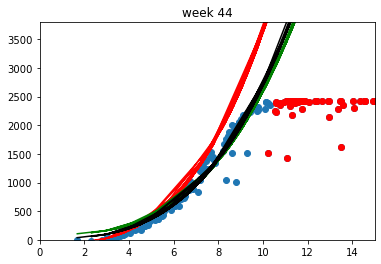

W_diff: -67.36209161864775
Pw_diff: 1586.1660187123534
Pw_diff_normal: 281.238805833283
Pw_diff_anom: 4848.484050910029
is_power_curtailment: True
power_iqr: 60.854166666666515
max_power/10: 34.51083333333333
wind_difference: 0.23909657320872268
week_difference: -0.019519114756810015
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


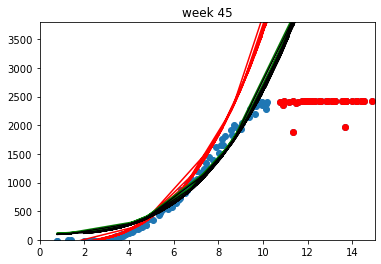

W_diff: -18.184083766520736
Pw_diff: 2893.6582227438835
Pw_diff_normal: 186.31634241104652
Pw_diff_anom: 8768.079283843435
is_power_curtailment: True
power_iqr: 0.0500000000001819
max_power/10: 34.51083333333333
wind_difference: 0.4260124610591901
week_difference: -0.005269094371290388
is_power_shift: Not Power Shift


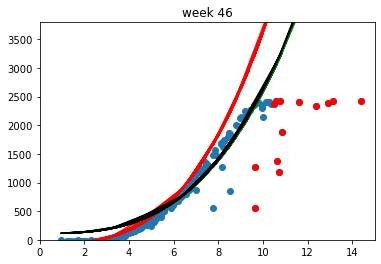

W_diff: -1.1873274754020604
Pw_diff: 508.93979206726345
Pw_diff_normal: 179.6336970115649
Pw_diff_anom: 4131.306837679951
is_power_curtailment: False
power_iqr: 914.8749999999998
max_power/10: 34.51083333333333
wind_difference: 0.266355140186916
week_difference: -0.0003440448580113666
is_power_shift: Not Power Shift


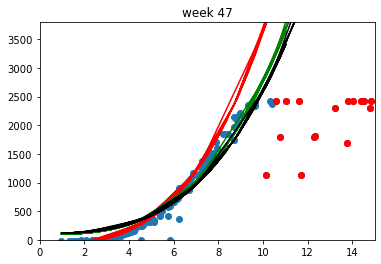

W_diff: 18.308581356405632
Pw_diff: 1337.6226865926085
Pw_diff_normal: 103.6362592476827
Pw_diff_anom: 9117.102337245404
is_power_curtailment: False
power_iqr: 356.77500000000055
max_power/10: 34.51083333333333
wind_difference: 0.38084112149532706
week_difference: 0.00530516930135145
is_power_shift: Not Power Shift


/var/folders/l1/897fydcj4fvbcv040d0tvdl40000gn/T/ipykernel_54478/1257740459.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["anomally_type"][total_mask] = "Power_Curtailments"


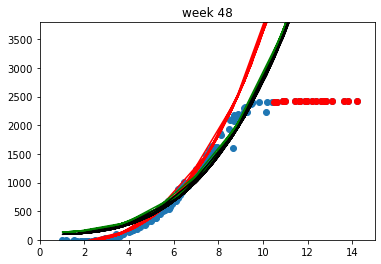

W_diff: -41.48202371061106
Pw_diff: 562.1553166824732
Pw_diff_normal: 99.82179812027353
Pw_diff_anom: 4187.823435933405
is_power_curtailment: True
power_iqr: 0.041666666666515084
max_power/10: 34.51083333333333
wind_difference: 0.17289719626168232
week_difference: -0.012020000592261675
is_power_shift: Not Power Shift


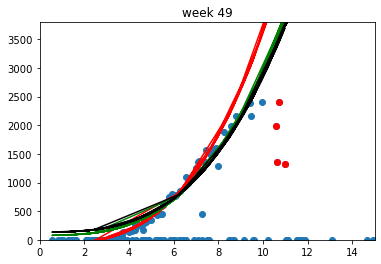

W_diff: 55.336828886507575
Pw_diff: 768.8585350989053
Pw_diff_normal: 721.4189984896037
Pw_diff_anom: 2713.8795360802656
is_power_curtailment: False
power_iqr: 744.7875000000001
max_power/10: 34.51083333333333
wind_difference: 0.017912772585669843
week_difference: 0.016034625519476757
is_power_shift: Not Power Shift


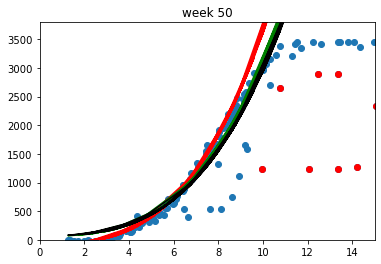

W_diff: 8.865139217433944
Pw_diff: 1043.4825476026876
Pw_diff_normal: 735.0457160621041
Pw_diff_anom: 6492.533238152992
is_power_curtailment: False
power_iqr: 1653.0499999999995
max_power/10: 34.51083333333333
wind_difference: 0.2873831775700934
week_difference: 0.002568798942583424
is_power_shift: Not Power Shift


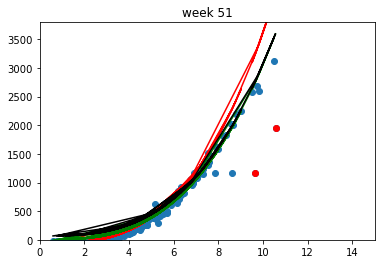

W_diff: 70.91162537546452
Pw_diff: 89.39315970574178
Pw_diff_normal: 63.956574761073675
Pw_diff_anom: 2200.629710113195
is_power_curtailment: False
power_iqr: 393.99166666666656
max_power/10: 34.51083333333333
wind_difference: 0.04205607476635516
week_difference: 0.020547642153564687
is_power_shift: Not Power Shift


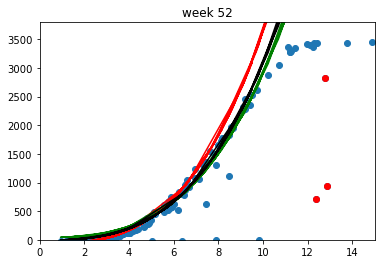

W_diff: -43.51462799671599
Pw_diff: 527.6266224974711
Pw_diff_normal: 412.67752107844115
Pw_diff_anom: 5930.234389191875
is_power_curtailment: False
power_iqr: 1056.5
max_power/10: 34.51083333333333
wind_difference: 0.021806853582554523
week_difference: -0.012608976310834566
is_power_shift: Not Power Shift


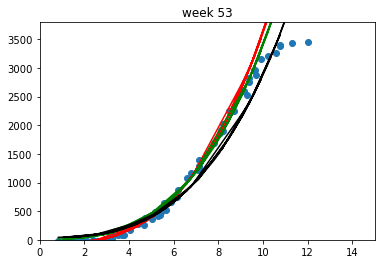

W_diff: 24.277432187240528
Pw_diff: 138.2286947079686
Pw_diff_normal: 138.2286947079686
Pw_diff_anom: nan
is_power_curtailment: False
power_iqr: nan
max_power/10: 34.51083333333333
wind_difference: nan
week_difference: 0.0070347278933399265
is_power_shift: Not Power Shift


In [18]:
# This is the final part
# We run the function in a for loop for every week in the df_by_week
# we choose the LR model (could be another one)
# We can decide which things we want to print. In this case we decide to print some indicators that helped us to tune the model

prev_week_model = None
my_list = []
for name,group in (df_by_week):
    stats_dict = power_curve_stats(group, prev_week_model)
    my_list.append(stats_dict)
    plt.figure()
    plot_power_curve(group,stats_dict["lr_model"], stats_dict["anomalies"], prev_week_model)
    prev_week_model = stats_dict["lr_model"]
    plt.title("week " + str(name))
    plt.show()
    print(f'W_diff: {stats_dict["week_diff"]}')
    print(f'Pw_diff: {stats_dict["power_diff"]}')
    print(f'Pw_diff_normal: {stats_dict["power_diff_normal"]}')
    print(f'Pw_diff_anom: {stats_dict["power_diff_anom"]}')
    print(f'is_power_curtailment: {stats_dict["is_power_curtailmemt"]}')
    print(f'power_iqr: {stats_dict["power_iqr"]}')
    print(f'max_power/10: {global_stats["max_power"]/100}')
    print(f'wind_difference: {stats_dict["anom_wind_diff"]/ global_stats["max_wind_speed"]}')
    print(f'week_difference: {stats_dict["week_diff"] / global_stats["max_power"]}')
    print(f'is_power_shift: {stats_dict["is_power_shift"]}')
pc_stats= pd.DataFrame(my_list)

1)STD of power anomalies / week
2)STD of wind speed anomalies / week
3)STD of power normal / week
4)STD of wind speed normal / week
5) 1)/2)
6) 3)/4)
7) Anomalies per week / total data points
8) Average distance of anomalies from the regression 


# Stats

In [19]:
columns_list = ['std_power_anom', 'std_power_normal', 'std_speed_anom',
       'std_speed_normal', 'ratio_power_wind_anom', 'ratio_power_wind_normal',
       'power_diff', 'power_diff_normal', 'power_diff_anom',
        'week_diff']

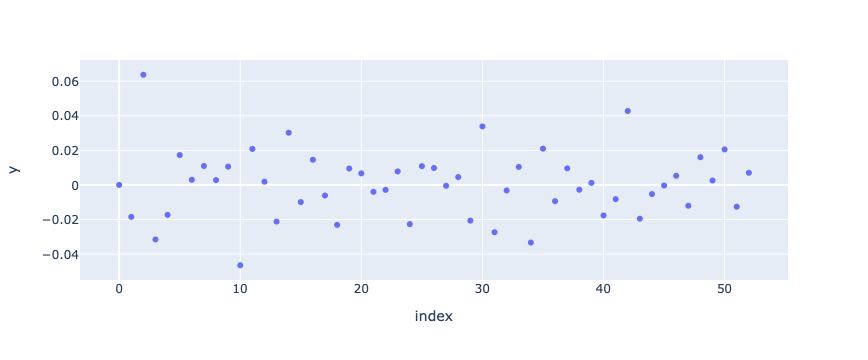

In [20]:
fig = px.scatter(pc_stats, x = pc_stats.index, y =pc_stats["week_diff"]/global_stats["max_power"])
fig.show()

# DF preparation

In [21]:
# The following part of the Script has the objective to prepare a DF for a machine learning model
# The DF that is exported in csv format should be imported in the supervised_ML_model
df.columns

Index(['ID', 'problem_class', 'datetime', 'environment_air_temperature_avg',
       'environment_wind_speed_avg', 'grid_power_active_avg',
       'nacelle_direction_avg', 'rotor_blades_pitch_angle_avg',
       'rotor_rotation_speed_avg', 'week', 'cubic_wind_speed', 'anomally_type',
       'prediction', 'power_diff'],
      dtype='object')

In [22]:
#we define the columns we want to work with
df_X =df[['ID', 'datetime', 'environment_air_temperature_avg',
       'environment_wind_speed_avg', 'grid_power_active_avg',
        'rotor_blades_pitch_angle_avg',
       'rotor_rotation_speed_avg', 'week',
       'prediction', 'power_diff']].copy()

In [23]:
#we scale tha power data for the grid power and for the rotor speed
df_X["grid_power_active_avg"] = df_X["grid_power_active_avg"] / df_X["grid_power_active_avg"].max()

In [24]:
df_X["rotor_rotation_speed_avg"] = df_X['rotor_rotation_speed_avg'] / df_X['rotor_rotation_speed_avg'].max()

In [25]:
#we create DF with the information from the dictionary in pc_stats
df_SD = pc_stats[["week_diff","power_iqr","anom_wind_diff"]].copy()
df_SD["week"] = df_SD.index

In [26]:
#the following loop asigns the anomalies detected to each data point.
# The anomalies are all in one cell per week and this fuction breaks that cell and asigns the values inside
# to the correct row(datapoint)
my_list= []
for index,row in pc_stats.iterrows():
    is_power_shift = (row["is_power_shift"] == "Probably") or (row["is_power_shift"] == "Very Likely")
    is_power_curtailment = (row["is_power_curtailmemt"] == True)
    anomaly = row["anomalies"].copy()
    if is_power_shift:
        anomaly.iloc[:] = "Power Shift"
        my_list.append(anomaly)
    elif is_power_curtailment:
        anomaly = anomaly.map({True:"Power Curtailment", False: "Normal"})
        my_list.append(anomaly)
    else:
        anomaly.iloc[:] = "Normal"
        my_list.append(anomaly)

df_L = pd.DataFrame(pd.concat(my_list))
df_L.columns = ["anomalies"]


In [27]:
#finaly we have the DF join and the DF is ready to be exported as a .csv file
df_ML = df_X.reset_index().merge(df_SD, on = "week", how = "left").set_index("index")
df_ML = df_ML.join(df_L)

In [28]:
df_ML.to_csv("/Users/francopallitto/Documents/DS_projects/nispera/data/interim/df_ML_"+(ID)+".csv")